Код, который давали в учебнике на плюсах, я взяла у ребят, которые его переписали на питон. К сожалению, нет времени (сил) сейчас переписывать и отлаживать программу:)

In [243]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [203]:
def copysign(x, y):
    return abs(x)*np.sign(y)

In [204]:
# n, l -квантовые числа
# zeta - заряд
# mesh - размер сетки
# dx - шаг сетки
# r, sqr, r2 - сетки (массивы)
# vpot - потенциал (массив)
# y - решение УШ на радиальной сетке размером mesh + 1
def solve_sheq(n, l, zeta, mesh, dx, r, sqr, r2, vpot, y):
    #solve the schroedinger equation in radial coordinates on a
    #logarithmic grid by Numerov method - atomic (Ry) units
    ddx12 = dx * dx / 12.0
    # Computing 2nd power
    sqlhf = (l + 0.5) * (l + 0.5)
    x2l2 = (2.0 * l + 2.0)
    # set initial lower and upper bounds to the eigenvalue
    eup = vpot[mesh]
    elw = eup
    for i in range(mesh + 1):
        elw = min(elw, sqlhf / r2[i] + vpot[i])
    assert(eup - elw >= 10**(-10))
    e = (elw + eup) * 0.5
    f = np.zeros(mesh + 1)
    kkk = 0
    while(True):
        # this is the entry point for the solution at fixed energy
        kkk += 1
        # set up the f-function and determine the position of its last */
        # change of sign */
        # f < 0 (approximately) means classically allowed   region */
        # f > 0         "         "        "      forbidden   " */
        icl = -1
        f[0] = ddx12 * (sqlhf + r2[0] * (vpot[0] - e))
        for i in range(1 , mesh + 1):
            f[i] = ddx12 * (sqlhf + r2[i] * (vpot[i] - e))
            # beware: if f(i) is exactly zero the change of sign is not observed
            # the following line is a trick to prevent missing a change of sign
            # in this unlikely but not impossible case:
            if (f[i] == 0.):
                f[i] = 1e-20
            if (f[i] != copysign(f[i], f[i - 1])):
                icl = i
        if (icl < 0):
            print("solve_sheq: no classical turning point")
            assert(icl >= 0)
        if (icl < 0 or icl >= mesh):
            eup = e
            e = (eup + elw) * 0.5
            continue
        # f function as required by numerov method
        for i in range(mesh + 1):
            f[i] = 1.0 - f[i]
            y[i] = 0.0
        # determination of the wave-function in the first two points
        nodes = n - l - 1
        y[0] = r[0]**(l + 1) * (1. - zeta * 2. * r[0] / x2l2) / sqr[0]
        y[1] = r[1]**(l + 1) * (1. - zeta * 2. * r[1] / x2l2) / sqr[1]
        # outward integration, count number of crossings
        ncross = 0
        for i in range(1, icl):
            y[i + 1] = ((12. - f[i] * 10.) * y[i] - f[i - 1] * y[i - 1]) / f[i + 1]
            if (y[i] != copysign(y[i], y[i + 1])):
                ncross += 1
        fac = y[icl]
        # check number of crossings
        if (ncross != nodes):
            if (kkk > 100):
                print("error in solve_sheq: too many iterations\n")
                assert(kkk <= 100)
            if (ncross > nodes):
                eup = e
            else:
                elw = e
            e = (eup + elw) * 0.5
            continue
        # determination of the wave-function in the last two points
        # assuming y(mesh+1) = 0 and y(mesh) = dx
        y[mesh] = dx
        y[mesh - 1] = (12. - f[mesh] * 10.) * y[mesh] / f[mesh - 1]
        # inward integration
        for i in range (mesh - 1, icl, -1):
            y[i - 1] = ((12. - f[i] * 10.) * y[i] - f[i + 1] * y[i + 1]) / f[i - 1]
            if (y[i - 1] > 1e10):
                for j in range(mesh, i - 2, -1):
                    y[j] /= y[i - 1]
        # rescale function to match at the classical turning point (icl)
        fac /= y[icl]
        for i in range(icl, mesh + 1):
            y[i] *= fac
        # normalize on the segment
        norm = 0.0
        for i in range(1, mesh + 1):
            norm += y[i] * y[i] * r2[i] * dx
        norm = np.sqrt(norm)
        for i in range(mesh + 1):
            y[i] /= norm
        # find the value of the cusp at the matching point (icl)
        i = icl
        ycusp = (y[i - 1] * f[i - 1] + f[i + 1] * y[i + 1] + f[i] * 10.* y[i]) / 12.
        dfcusp = f[i] * (y[i] / ycusp - 1.)
        # eigenvalue update using perturbation theory
        de = dfcusp / ddx12 * ycusp * ycusp * dx
        if (de > 0.):
            elw = e
        if (de < 0.):
            eup = e
        # prevent e to go out of bounds, i.e. e > eup or e < elw
        # (might happen far from convergence)
        e = e + de
        e = min(e, eup)
        e = max(e, elw)
        if (kkk > 100):
            print("error in solve_sheq: too many iterations\n")
            assert(kkk <= 100)
        if (abs(de) > 1e-10):
            continue
        # convergence has been achieved
        break
    print("convergence achieved at iter # {0}, de = {1}\n".format(kkk, de))
    return e 

In [205]:
def do_mesh(mesh, zmesh, xmin, dx, rmax, r, sqr, r2):
    # initialize grid
    x = 0
    for i in range(mesh + 1):
        x = xmin + dx * i
        r[i] = np.exp(x) / zmesh
        sqr[i] = np.sqrt(r[i])
        r2[i] = r[i] * r[i]
    print(" radial mesh information:")
    print(" dx   = {}".format(dx) + ", xmin = {}".format(xmin) + ", zmesh = {}".format(zmesh))
    print(" mesh = {}".format(mesh) + ", r(0) = {}".format(r[0]) + ", r(mesh) = {}".format(r[mesh]))
    return mesh

In [206]:
def init_pot(zeta, mesh, r, vpot):
    # initialize potential
    with open("pot.out", "w") as f:
        for i in range(mesh + 1):
            vpot[i] = -2 * zeta / r[i]
            f.write("{0}, {1}\n".format(r[i], vpot[i]))

In [207]:
def rho_of_r(mesh, r, r2, y, rho):
    # compute the charge density of a He-like atom
    fpi = 4 * np.pi
    nelec = 2
    for i in range(mesh + 1):
        rho[i] = nelec * y[i]**2 * r[i] / (fpi*r2[i])

In [208]:
def v_of_rho(mesh, dx, r, r2, rho, vhx):
    # compute the Hartree + Exchange potential for an He-like atom
    # Exchange cancels exactly half of the Hartree result for both
    # potential and energy
    e2 = 2.0
    '''calculate the Hartree potential and energy by integrating the
    electric field generated by the electronic charge.
    This is done in 2 steps

    1) calculate the charge inside a sphere and fill vhx with the
    electric field generated by this charge'''
    charge = 0.0
    fpi = 4.0*np.pi
    for i in range(mesh + 1):
        charge = charge + rho[i] * fpi * r2[i] * r[i] * dx
        vhx[i] = e2 * charge / r2[i]
    # (the total charge is written in output as a check)
    print("Total charge = {}\n".format(charge))
    '''2) integrate the electric field from +\infty to r to get the potential
    and integrate V_{Hartree}*rho to get the energy'''
    ehx = 0.0
    vhx[mesh] = e2 * charge / r[mesh]
    for i in range(mesh - 1, -1, -1):
        vhx[i] = vhx[i + 1] + vhx[i] * r[i] * dx
        ehx = ehx + vhx[i] * rho[i] * fpi * r2[i] * r[i] * dx
    ehx = ehx / 2.0
    '''Exchange cancels exactly half of the Hartree result for both
    potential and energy'''
    ehx = 0.5 * ehx
    for i in range(mesh + 1):
        vhx[i] = 0.5 * vhx[i]
    return ehx

In [209]:
def calculate_1s(beta = 0.1,
    zeta = 2,
    tol = 1,
    rmax = 100.0,
    xmin = -6.0,
    dx = 0.01,
    n = 1,
    l = 0):


    print("Hartree-Fock calculation for Helium-like atoms\n")
    print(" ATOMIC CHARGE = ", zeta)
    print(" zeta = {}\n".format(zeta))
    if (zeta < 2.0):
        print("zeta should be > 2\n")
        assert(zeta > 2)
    print(" MIXING PARAMETER beta [0.0-1.0] = ", beta)
    print(" beta = {}\n".format(beta))
    if (beta <= 0.0 or beta > 1.0):
        print("beta out of range\n")
        assert(beta > 0.0)
        assert(beta <= 1.0)
    print(" SCF ACCURACY (Ry) = ", tol)
    if (tol <= 0):
        print("tol should be strictly positive\n")
        assert(tol > 0)

    # initialize logarithmic mesh
    zmesh = zeta
    
    mesh = int(((np.log(zmesh * rmax) - xmin) / dx))
    r = np.zeros(mesh + 1)
    r2 = np.zeros(mesh + 1)
    sqr = np.zeros(mesh + 1)

    do_mesh(mesh, zmesh, xmin, dx, rmax, r, sqr, r2)

    # initialize the potential
    vpot = np.zeros(mesh + 1)
    init_pot(zeta, mesh, r, vpot)

    # The GS configuration for helium-like atoms is (1s)**2
    #n = 1
    #l = 0

    vscf = np.zeros(mesh + 1)
    for i in range(mesh + 1):
        vscf[i] = vpot[i]

    # SCF cycle
    y = np.zeros(mesh + 1)
    rho = np.zeros(mesh + 1)
    vhx = np.zeros(mesh + 1)
    deltav = np.zeros(mesh + 1)

    # the variational correction "de" is used to check for self-consistency
    de = 2.0 * tol
    
    Total_energies = []
    iteration = 1
    while (abs(de) > tol):
        print("####################################################")
        print(" SCF iteration # {}".format(iteration))
        # solve schroedinger equation in radial coordinates by Numerov method
        e = solve_sheq(n, l, zeta, mesh, dx, r, sqr, r2, vscf, y)
        # calculate the charge density from the wfc
        rho_of_r(mesh, r, r2, y, rho)
        # calculate the Hartree + Exchange potential and energy
        ehx = v_of_rho(mesh, dx, r, r2, rho, vhx)
        # calculate the kinetic energy and the energy in the external potential
        evion = 0.0
        ekin = 2.0 * e
        for i in range(mesh + 1):
            evion = evion + vpot[i] * rho[i] * 4.*np.pi * r2[i] * r[i] * dx
            ekin = ekin - vscf[i] * rho[i] * 4.*np.pi * r2[i] * r[i] * dx
        de = 0.0
        for i in range(mesh + 1):
            deltav[i] = vpot[i] + vhx[i] - vscf[i]
            vscf[i] = vscf[i] + beta * deltav[i]
            de = de + deltav[i] * rho[i] * 4.*np.pi * r2[i] * r[i] * dx
        '''write out the eigenvalue energy
        to be compared with the external potential'''
        etot = 2.0 * e - ehx + de
        etot1 = ekin + evion + ehx
        print("eigenvalue  = {}".format(e))
        print("Eigenvalue energy      {}".format(2 * e))
        print("Kinetic energy         {}".format(ekin))
        print("External pot. energy   {}".format(evion))
        print("Hartree+Exch. energy   {}".format(ehx))
        print("Variational correct.   {}".format(de))
        print("Total energy           {0} {1}".format(etot, etot1))
        Total_energies.append(etot)
        print("Virial check           {}".format(-(evion + ehx) / ekin))

        iteration += 1
    print(" SCF Convergence has been achieved")
    # write to file pot.out
    with open("pot.out", "w") as f:
        for i in range(mesh + 1):
            f.write("{0} {1} {2} {3}\n".format(r[i], vpot[i], vhx[i], vscf[i]))
    with open("wfc.out", "w") as f:
        for i in range(mesh + 1):
            f.write("{0} {1} {2} {3}\n".format(r[i], y[i] / sqr[i], y[i] * sqr[i], e))
        f.write("\n\n")
    return Total_energies, zeta, mesh, dx, r, sqr, r2, vscf, y

In [210]:
def calculate_any_nl(n, l, zeta, mesh, dx, r, sqr, r2, vscf, y):
    print(" compute additional single-particle states")
    assert(n > 1)
    assert(n >= l + 1)
    # solve the schroedinger equation in radial coordinates by Numerov method
    e = solve_sheq(n, l, zeta, mesh, dx, r, sqr, r2, vscf, y)
    print("eigenvalue {0} {1} = {2}".format(n, l, e))

    with open("wfc.out", "w") as f:
        for i in range(mesh + 1):
            f.write("{0} {1} {2} {3}\n".format(r[i], y[i] / sqr[i], y[i] * sqr[i], e))
        f.write("\n\n")
    return zeta, mesh, dx, r, sqr, r2, vscf, y

# 1.	Исследуйте поведение самосогласованного решения, убедитесь, что полная энергия монотонно уменьшается в самосогласованном цикле.

In [211]:
Total_energies, zeta, mesh, dx, r, sqr, r2, vscf, y = calculate_1s(beta = 0.1,
    zeta = 2,
    tol = 0.01,
    rmax = 100.0,
    xmin = -6.0,
    dx = 0.01,
    n = 1,
    l = 0)

Hartree-Fock calculation for Helium-like atoms

 ATOMIC CHARGE =  2
 zeta = 2

 MIXING PARAMETER beta [0.0-1.0] =  0.1
 beta = 0.1

 SCF ACCURACY (Ry) =  0.01
 radial mesh information:
 dx   = 0.01, xmin = -6.0, zmesh = 2
 mesh = 1129, r(0) = 0.0012393760883331792, r(mesh) = 99.17171270469068
####################################################
 SCF iteration # 1
convergence achieved at iter # 7, de = -5.21555174586824e-11

Total charge = 2.0000000012123875

eigenvalue  = -4.0000002470642295
Eigenvalue energy      -8.000000494128459
Kinetic energy         7.999807295073995
External pot. energy   -15.999807789202459
Hartree+Exch. energy   2.5124325016721483
Variational correct.   5.024865003344319
Total energy           -5.487567992456288 -5.4875679924563165
Virial check           1.6859625226016846
####################################################
 SCF iteration # 2
convergence achieved at iter # 7, de = -8.348437199288738e-11

Total charge = 2.0000000011713386

eigenvalue  = -3.749

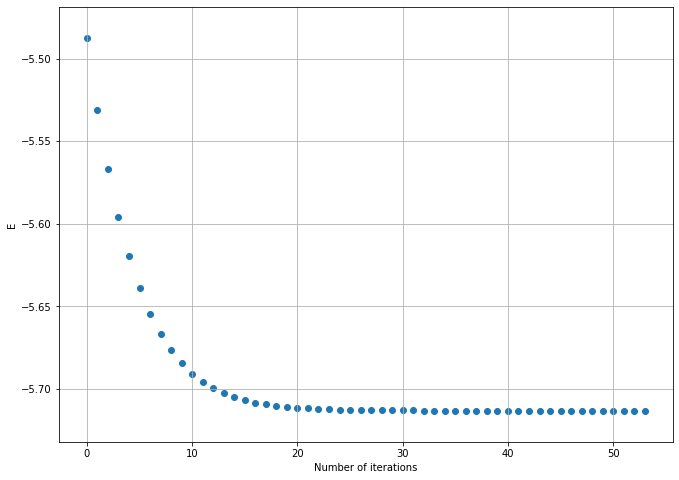

In [212]:
plt.figure(figsize = (11, 8))
plt.scatter(range(len(Total_energies)), Total_energies)
plt.xlabel('Number of iterations')
plt.ylabel('E')
plt.grid()

Сначала энергия основого состояния монотонно уменьшается, а затем выходит на константу, что говорит о том, что мы достигли самосогласовонности. 

# 2.	Сравните энергию основного состояния, полученную данным методом и другими методами.

Text(0, 0.5, 'E')

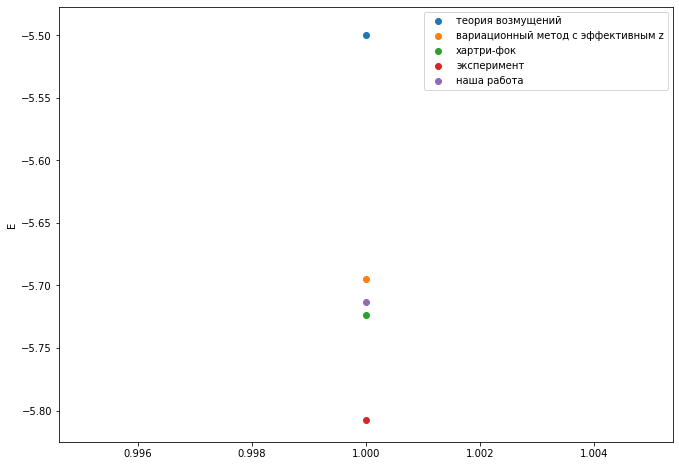

In [213]:
E = [-5.5, -5.695, -5.72336, -5.8074]
E.append(Total_energies[-1])
labels = ['теория возмущений', 'вариационный метод с эффективным z', 'хартри-фок', 'эксперимент', "наша работа"]
plt.figure(figsize = (11, 8))
for i in range(len(E)):
    plt.scatter([1], E[i], label = labels[i])
plt.legend()
plt.ylabel('E')

Истинная энергия основного состояния, полученная экспериментально, находится довольно низко относительно энергий, полученных с помощью теории или расчетов. При этом теория возмущений дает самый далекий от реальности результат, а вариационный метод, хартри-фок и хартри находятся довольно близко друг к другу.

# 3.	Нарисуйте орбитали для разных n и l. Заметьте, что орбитали и их соответствующие собственные значения становятся водородоподобными для больших n. Вы можете объяснить почему?

In [214]:
Total_energies, zeta, mesh, dx, r, sqr, r2, vscf, y = calculate_1s(beta = 0.1,
    zeta = 2,
    tol = 0.01,
    rmax = 100.0,
    xmin = -6.0,
    dx = 0.01,
    n = 1,
    l = 0)
R1 = [y[i]/sqr[i] for i in range(len(y))]
r1 = r[:]

Hartree-Fock calculation for Helium-like atoms

 ATOMIC CHARGE =  2
 zeta = 2

 MIXING PARAMETER beta [0.0-1.0] =  0.1
 beta = 0.1

 SCF ACCURACY (Ry) =  0.01
 radial mesh information:
 dx   = 0.01, xmin = -6.0, zmesh = 2
 mesh = 1129, r(0) = 0.0012393760883331792, r(mesh) = 99.17171270469068
####################################################
 SCF iteration # 1
convergence achieved at iter # 7, de = -5.21555174586824e-11

Total charge = 2.0000000012123875

eigenvalue  = -4.0000002470642295
Eigenvalue energy      -8.000000494128459
Kinetic energy         7.999807295073995
External pot. energy   -15.999807789202459
Hartree+Exch. energy   2.5124325016721483
Variational correct.   5.024865003344319
Total energy           -5.487567992456288 -5.4875679924563165
Virial check           1.6859625226016846
####################################################
 SCF iteration # 2
convergence achieved at iter # 7, de = -8.348437199288738e-11

Total charge = 2.0000000011713386

eigenvalue  = -3.749

 compute additional single-particle states
convergence achieved at iter # 11, de = -1.7288549201370774e-13

eigenvalue 2 0 = -0.31582491161100207
 compute additional single-particle states
convergence achieved at iter # 14, de = -3.507350725450878e-14

eigenvalue 3 0 = -0.12901640496970823
 compute additional single-particle states
convergence achieved at iter # 10, de = 3.9150217128564386e-14

eigenvalue 4 0 = -0.06979452637530009
 compute additional single-particle states
convergence achieved at iter # 13, de = -1.0112850103081567e-14

eigenvalue 5 0 = -0.04368362043817873
 compute additional single-particle states
convergence achieved at iter # 15, de = -5.926359086943725e-12

eigenvalue 6 0 = -0.0298965220499285
 compute additional single-particle states
convergence achieved at iter # 18, de = -4.5158261551796605e-15

eigenvalue 7 0 = -0.021061162610207986


(0, 10)

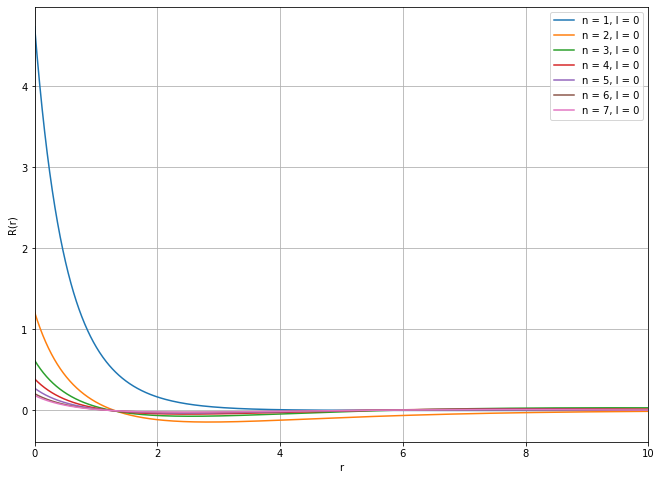

In [223]:
#сначала посмотрим разные n при l = 0
labels = ['n = 1, l = 0', 'n = 2, l = 0', 'n = 3, l = 0', 'n = 4, l = 0', 'n = 5, l = 0', 'n = 6, l = 0', 'n = 7, l = 0']
plt.figure(figsize = (11, 8))
plt.plot(r1, R1, label = labels[0])
for l in range(2, 8):
    zeta1, mesh1, dx1, r1, sqr1, r21, vscf1, y1 = calculate_any_nl(l, 0, zeta, mesh, dx, r, sqr, r2, vscf, y)
    R, r = [], []
    with open('wfc.out', 'r') as f:
        lines = f.readlines()
        for line in lines[:-2]:
            r.append(float(line.split()[0]))
            R.append(float(line.split()[1]))
    plt.plot(r, R, label = labels[l-1])
plt.legend()
plt.grid()
plt.ylabel('R(r)')
plt.xlabel('r')
plt.xlim(0, 10)

Text(0.5, 0, 'n')

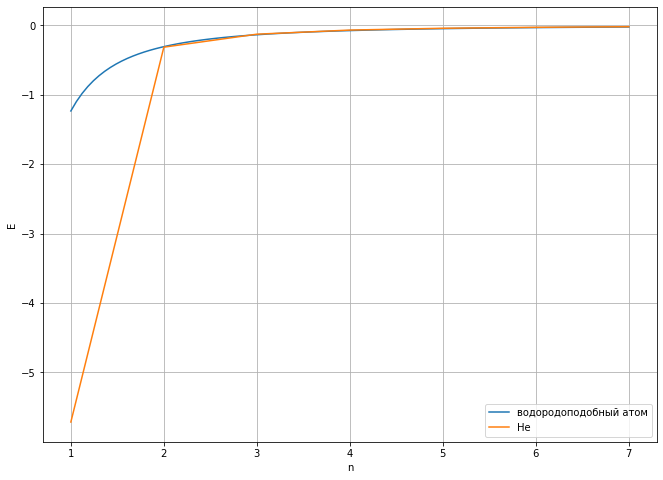

In [247]:
n = [1, 2, 3, 4, 5, 6, 7]
e_he = [-5.713182114620001, -0.31582491161100207, -0.12901640496970823, -0.06979452637530009, -0.04368362043817873, -0.0298965220499285, -0.021061162610207986]
#e_h = [-1, -0.25, -0.111111, -0.0625, -0.03999985, -0.02770388, -0.02068910]
#e_h1 = [-2.84765625, -0.71191406, -0.31640625, -0.17797852, -0.11390625, -0.07910156, -0.05811491]
#e_h2 = [-4, -1, -0.44444445, -0.25000000, -0.16, -0.11111111, -0.08163265]
labels = ['He', 'водородоподобный атом']
def func(x, b):
    return(b*x**(-2))
popt, pcov = curve_fit(func, n[1:], e_he[1:])
plt.figure(figsize = (11, 8))
a = np.linspace(1, 7, 100)
plt.plot(a, func(a, *popt), label = labels[1])
plt.plot(n, e_he, label = labels[0])
plt.legend()
plt.grid()
plt.ylabel('E')
plt.xlabel('n')

 compute additional single-particle states
convergence achieved at iter # 14, de = -3.507350725450878e-14

eigenvalue 3 0 = -0.12901640496970823
 compute additional single-particle states
convergence achieved at iter # 7, de = 2.717898655050035e-14

eigenvalue 3 1 = -0.11244823180761991
 compute additional single-particle states
convergence achieved at iter # 6, de = -8.184147014537768e-11

eigenvalue 3 2 = -0.11087867043058221


(0, 10)

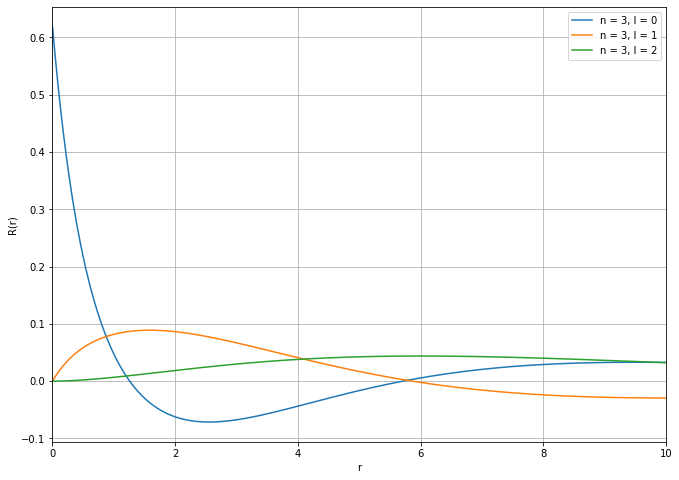

In [225]:
#теперь посмотрим разные l при n = 3
labels = ['n = 3, l = 0', 'n = 3, l = 1', 'n = 3, l = 2']
plt.figure(figsize = (11, 8))
for l in range(3):
    zeta1, mesh1, dx1, r1, sqr1, r21, vscf1, y1 = calculate_any_nl(3, l, zeta, mesh, dx, r, sqr, r2, vscf, y)
    R, r = [], []
    with open('wfc.out', 'r') as f:
        lines = f.readlines()
        for line in lines[:-2]:
            r.append(float(line.split()[0]))
            R.append(float(line.split()[1]))
    plt.plot(r, R, label = labels[l])
plt.legend()
plt.grid()
plt.ylabel('R(r)')
plt.xlabel('r')
plt.xlim(0, 10)

# 4.	Если Вы не знаете ответа на предыдущий вопрос: нарисуйте график Vscf (файл pot.out) и сравните вид самосогласованного потенциала с кулоновским слагаемым –Zq^2 / r. Что вы замечаете?

In [226]:
Total_energies, zeta, mesh, dx, r, sqr, r2, vscf, y = calculate_1s(beta = 0.1,
    zeta = 2,
    tol = 0.01,
    rmax = 100.0,
    xmin = -6.0,
    dx = 0.01,
    n = 1,
    l = 0)

Hartree-Fock calculation for Helium-like atoms

 ATOMIC CHARGE =  2
 zeta = 2

 MIXING PARAMETER beta [0.0-1.0] =  0.1
 beta = 0.1

 SCF ACCURACY (Ry) =  0.01
 radial mesh information:
 dx   = 0.01, xmin = -6.0, zmesh = 2
 mesh = 1129, r(0) = 0.0012393760883331792, r(mesh) = 99.17171270469068
####################################################
 SCF iteration # 1
convergence achieved at iter # 7, de = -5.21555174586824e-11

Total charge = 2.0000000012123875

eigenvalue  = -4.0000002470642295
Eigenvalue energy      -8.000000494128459
Kinetic energy         7.999807295073995
External pot. energy   -15.999807789202459
Hartree+Exch. energy   2.5124325016721483
Variational correct.   5.024865003344319
Total energy           -5.487567992456288 -5.4875679924563165
Virial check           1.6859625226016846
####################################################
 SCF iteration # 2
convergence achieved at iter # 7, de = -8.348437199288738e-11

Total charge = 2.0000000011713386

eigenvalue  = -3.749

(0, 20)

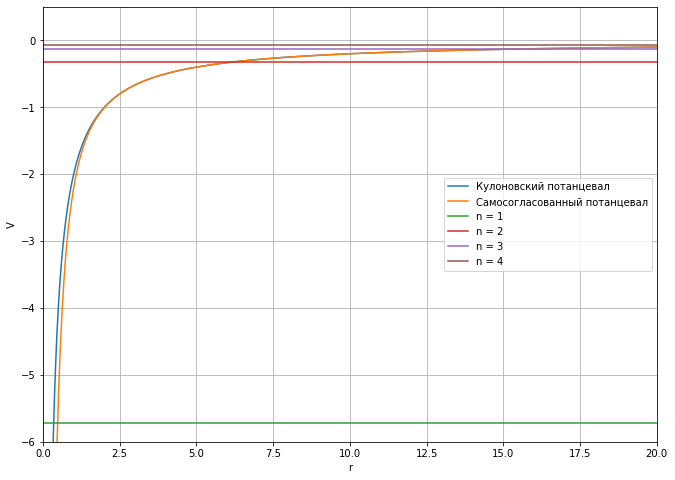

In [238]:
r,vscf = [], []
labels = ['Самосогласованный потанцевал', 'Кулоновский потанцевал']
e_he = [-5.713182114620001, -0.31582491161100207, -0.12901640496970823, -0.06979452637530009, -0.04368362043817873, -0.0298965220499285, -0.021061162610207986]
plt.figure(figsize = (11, 8))
with open('pot.out') as f:
    for line in f:
        r.append(float(line.split()[0]))
        vscf.append(float(line.split()[3]))
m = 0
plt.ylim(-6, 0.5)
plt.xlim(0, 10)
v = [-2/r[i] for i in range(len(r))]
plt.plot(r[m:], v[m:], label = labels[1])
plt.plot(r[m:], vscf[m:], label = labels[0])
for i in range(len(e_he)-3):
    plt.plot(r, [e_he[i] for j in range(len(r))], label = 'n = ' + str(i+1))
plt.legend()
plt.grid()
plt.ylabel('V')
plt.xlabel('r')
plt.xlim(0, 20)

Как мы можем видеть, уже для n = 2 потенциалы очень близко расположены друг к другу, поэтому итоговое значение энергии практически совпадает со значением для водородоподобного атома. 

# 5.	Нарисуйте 1s орбитали вместе с теми, что были получены с помощью кода hydrogen_radial для водорода (Z=1), He+ (Z=2) и промежуточного значения Z = 1.687.

In [112]:
Total_energies, zeta, mesh, dx, r, sqr, r2, vscf, y = calculate_1s(beta = 0.1,
    zeta = 2,
    tol = 0.01,
    rmax = 100.0,
    xmin = -6.0,
    dx = 0.01,
    n = 1,
    l = 0)
R1 = [y[i]/sqr[i] for i in range(len(y))]
r1 = r[:]

Hartree-Fock calculation for Helium-like atoms

 ATOMIC CHARGE =  2
 zeta = 2

 MIXING PARAMETER beta [0.0-1.0] =  0.1
 beta = 0.1

 SCF ACCURACY (Ry) =  0.01
 radial mesh information:
 dx   = 0.01, xmin = -6.0, zmesh = 2
 mesh = 1129, r(0) = 0.0012393760883331792, r(mesh) = 99.17171270469068
####################################################
 SCF iteration # 1
convergence achieved at iter # 7, de = -5.21555174586824e-11

Total charge = 2.0000000012123875

eigenvalue  = -4.0000002470642295
Eigenvalue energy      -8.000000494128459
Kinetic energy         7.999807295073995
External pot. energy   -15.999807789202459
Hartree+Exch. energy   2.5124325016721483
Variational correct.   5.024865003344319
Total energy           -5.487567992456288 -5.4875679924563165
Virial check           1.6859625226016846
####################################################
 SCF iteration # 2
convergence achieved at iter # 7, de = -8.348437199288738e-11

Total charge = 2.0000000011713386

eigenvalue  = -3.749

Text(0.5, 0, 'r')

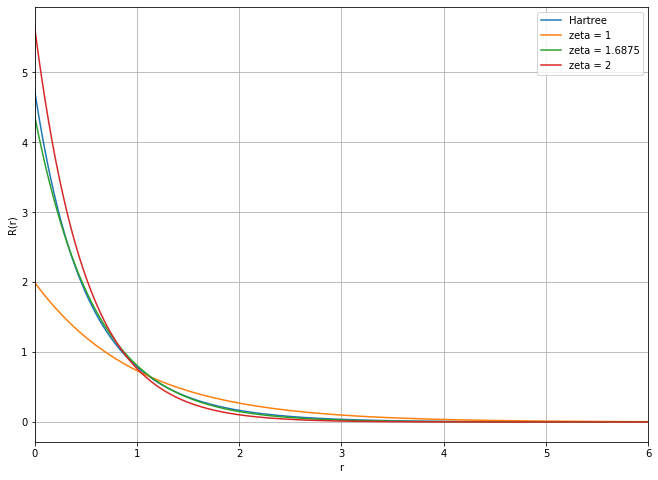

In [240]:
plt.figure(figsize = (11, 8))
plt.plot(r1, R1, label = 'Hartree')
labels = ['zeta = 1', 'zeta = 1.6875', 'zeta = 2']
j = 0
for zeta in [1.0, 1.6875, 2.0]:
    with open('wfc_'+str(zeta)+'.out', 'r') as f:
        r, R = [], []
        for i, line in enumerate(f):
            if i > 1:
                r.append(float(line.split()[0]))
                R.append(float(line.split()[1]))
        plt.plot(r, R, markersize = '1', label = labels[j])
    j += 1
plt.xlim(0, 6)
plt.legend()
plt.grid()
plt.ylabel('R(r)')
plt.xlabel('r')

Вф, полученная с помощью метода Хартри, и вф, полученная в приближении водородоподобного атома хорошо согласуются между собой. Это говорит о том, что наш самосогласованный потенциал с хорошей точностью может быть описан кулоновским потенциалом с эффективным зарядом z = 1.6875, который получается из-за экранировки ядра вторым электроном.